## Read and analyze the collected data

In [230]:
import sqlite3
import re

import pandas as pd
import numpy as np

from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline

In [231]:
def query_table(c,query):
    c.execute('SELECT * FROM {tn} WHERE {cn}="no"'.\
        format(coi='id', tn=query, cn='is_retweet'))

    check = c.fetchall()
    df = pd.DataFrame(check)
    df.columns = ['tweet_id', 'datetime', 'source', 'user_id',
                  'user_name','user_location',
                  'user_description','user_followers',
                  'user_friends','user_acc_age',
                  'user_verified','user_statuses','user_offset',
                  'user_lang','is_quote_status','favorited',
                  'retweeted','language','is_retweet',
                  'mentions','reply_to','retweet_text',
                  'retweet_user','text']

    return(df)

def trim_data(df,items):
    df = df[df['language'] == 'en']
    df = df.filter(items=items)
    return(df)

def clean_text(text):
    clean_tweets = []
    for tweet in text:
        clean = tweet.lower() # set to lowercase
        clean = re.sub('\n',' ',clean) # change newline to space
        clean = re.sub('&amp','&',clean) # fix ampersands
        clean = re.sub('#[^ ]*','',clean) # remove hashtags
        clean = re.sub('@[^ ]*','',clean) # remove mentions
        clean = re.sub('http[^ ]*','',clean) # remove links
        clean = re.sub('[^a-z0-9 ]','',clean) # remove non-alphanumerics
        clean = re.sub(' + ',' ',clean) # multi-spaces down to single spaces
        clean = clean.strip()
        clean_tweets.append(clean)
    return(clean_tweets)

def find_duplicates(text):
    cnt = Counter()
    duplicates = [False] * df.shape[0]
    for i,tweet in enumerate(text):
        cnt[tweet] += 1
        if cnt[tweet] > 1:
            duplicates[i] = True
    return(duplicates)

def find_short(text, min_len):
    length = [len(tweet.split(' ')) for tweet in text]
    too_short = [ln < min_len for ln in length]
    return(too_short)

def word_counter(df, text_col, terms):
    df['length'] = [len(tweet.split(' ')) for tweet in df[text_col]]
    for term in terms:
        df[term] = [len(re.findall('\\b'+term+'\\b', tweet)) for tweet in df[text_col]]
    return(df)

In [251]:
# connect to the database
sqlite_file = '20180402_hashtags_sample100000.sqlite'
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# get list of hashtags
queries = []
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    queries.append(name[0])

all_counts = []
for query in queries:
    # query data
    df = query_table(c,query)

    # add cleaner columns
    df = trim_data(df,['tweet_id', 'user_id','user_followers','text'])
    df['clean_text'] = clean_text(df['text'])
    df['duplicate'] = find_duplicates(df['clean_text'])
    df['short'] = find_short(df['clean_text'], 5)

    # trim data
    clean_df = df[~df['duplicate'] & ~df['short']].drop(['duplicate','short','text'], axis = 1)

    # count words
    #ey_words = ['i','you','we','mine','yours','ours','my','your','our']
    ownership_dictionary = ['mine','my','your','yours','our','ours']
    
    word_counts = word_counter(clean_df, 'clean_text', ownership_dictionary)
    possessives = [0] * word_counts.shape[0]
    for term in ownership_dictionary:
        possessives += word_counts[term]
    word_counts['possessive_count'] = possessives
    word_counts['contains_poss'] = possessives > 0
    word_counts['poss_per_word'] = possessives / word_counts['length']
    
    all_counts.append(word_counts)

In [252]:
info = [] ### plot poss_per_word over time to see when/if it stabilizes
for i,counts in enumerate(all_counts):
    qnum = count_df#qnum = count_df[count_df[q]]
    avg_len = np.mean(counts['length'])
    poss_per_tweet = np.mean(counts['contains_poss'])# * 100
    per_tweet_se = np.std(counts['contains_poss']) / np.sqrt(counts.shape[0])# * 100
    poss_per_word = np.mean(counts['poss_per_word'])# * 100
    per_word_se = np.std(counts['poss_per_word']) / np.sqrt(counts.shape[0])# * 100
    #log_poss_per_word = np.mean([np.log(tweet * 100) if tweet > 0 else 0 for tweet in counts['poss_per_word']])
    #log_per_word_se = np.std([np.log(tweet * 100) if tweet > 0 else 0 for tweet in counts['poss_per_word']])
    count = counts.shape[0]
    info.append([queries[i], avg_len,poss_per_tweet,per_tweet_se,
                 poss_per_word,per_word_se,count])
    
results = pd.DataFrame(info)
results.columns = ['hashtag','avg_len','poss_per_tweet','per_tweet_se',
                   'poss_per_word','per_word_se','count']
results = results.sort_values(by = 'count', ascending = False).reset_index(drop = True)
results

,hashtag,avg_len,poss_per_tweet,per_tweet_se,poss_per_word,per_word_se,count
0,mondaymotivation,17.077549,0.336764,0.003270,0.026301,0.000315,20890
1,worldautismawarenessday,18.723558,0.300481,0.010053,0.019597,0.000852,2080


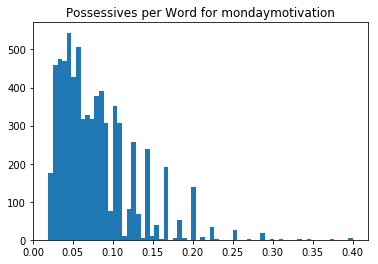

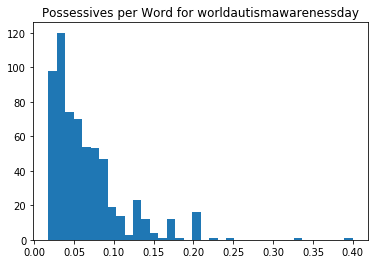

In [253]:
for i in range(len(all_counts)):
    posses = all_counts[i]['poss_per_word'][all_counts[i]['poss_per_word'] > 0]# * 100
    #posses = np.log(posses)

    plt.hist(posses, bins='auto')  # arguments are passed to np.histogram
    plt.title("Possessives per Word for " + queries[i])
    plt.show()

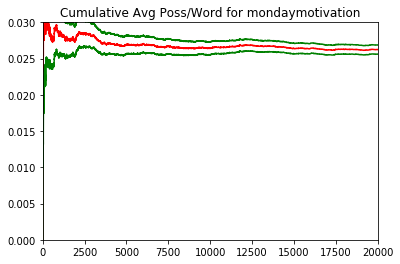

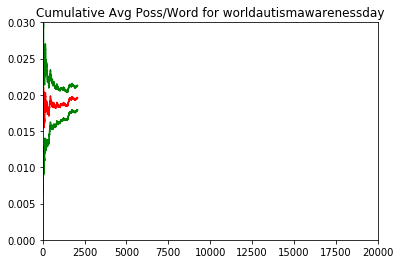

In [254]:
for i in range(len(all_counts)):
    #for j in range(10):
    #    shuffled = all_counts[i].sample(frac = 1).reset_index(drop = True)
    #    rate_cumsum = np.cumsum(shuffled.poss_per_word) / (shuffled.index+1)
    #    plt.plot(shuffled.index, rate_cumsum, 'r')

    shuffled = all_counts[i].sample(frac = 1).reset_index(drop = True)
    rate_cumsum = np.cumsum(shuffled.poss_per_word) / (shuffled.index+1)
    rate_cumstd = shuffled['poss_per_word'].expanding(min_periods=1).std()
    rate_cumse = rate_cumstd / np.sqrt(shuffled.index+1)
    plus_ci = rate_cumsum + 1.96 * rate_cumse
    minus_ci = rate_cumsum - 1.96 * rate_cumse
   
    plt.plot(shuffled.index, rate_cumsum, 'r')
    plt.plot(shuffled.index, plus_ci, 'g')
    plt.plot(shuffled.index, minus_ci, 'g')

    plt.xlim(0,20000)
    plt.ylim(0,0.03)
    plt.title("Cumulative Avg Poss/Word for " + queries[i])
    plt.show()

In [558]:
## count number of tweets by each user

cnt = Counter()
for tweet in df_1['user']: ## change df_1 to count_df
    cnt[tweet] += 1

keys = []
values = []
for key,value in cnt.items():
    keys.append(key)
    values.append(value)
    
user_df = pd.DataFrame({'user':keys,'count':values})
user_df.sort_values(by = 'count', ascending = False).reset_index(drop = True)[:5]

,count,user
0,174,1606528160
1,49,707576396298649600
2,44,2269619268
3,32,877252532510142468
4,28,561614650


In [222]:
# determine average lev distance between tweets by a given user

def levenshtein(seq1, seq2):
    # from: http://stackabuse.com/levenshtein-distance-and-text-similarity-in-python/
    size_x = len(seq1) + 1
    size_y = len(seq2) + 1
    matrix = np.zeros ((size_x, size_y))
    for x in range(size_x):
        matrix [x, 0] = x
    for y in range(size_y):
        matrix [0, y] = y

    for x in range(1, size_x):
        for y in range(1, size_y):
            if seq1[x-1] == seq2[y-1]:
                matrix [x,y] = min(
                    matrix[x-1, y] + 1,
                    matrix[x-1, y-1],
                    matrix[x, y-1] + 1
                )
            else:
                matrix [x,y] = min(
                    matrix[x-1,y] + 1,
                    matrix[x-1,y-1] + 1,
                    matrix[x,y-1] + 1
                )
    #print (matrix)
    return (matrix[size_x - 1, size_y - 1])

def avg_levens(tweets): ### this will be too slow!!! better to just take a bunch of random pairs?
    levens = []
    for item1 in tweets:
        for item2 in tweets[tweets != item1]:
            levens.append(levenshtein(item1,item2) / np.mean([len(item1),len(item2)]))
    return(np.mean(levens))

avg_levens(count_df[count_df['user'] == '1600214708']['clean_text']) ## and person must be above some cut-off to be included